# Q-Learnig: a simple tic tac toe implementation

Source: https://github.com/ajschumacher/ajschumacher.github.io/blob/master/20191103-q_learning_tic_tac_toe_briefly/q_learning_tic_tac_toe.ipynb

## Alternative implementations (even without NN):

https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542

https://plainenglish.io/blog/building-a-tic-tac-toe-game-with-reinforcement-learning-in-python

https://www.kaggle.com/code/dhanushkishore/a-self-learning-tic-tac-toe-program

https://nestedsoftware.com/2019/07/25/tic-tac-toe-with-tabular-q-learning-1kdn.139811.html

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import random
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker

In [2]:
# Utility functions

def new_board(size=3):
    return np.zeros(shape=(size, size))

def available_moves(board):
    return np.argwhere(board == 0)

def check_game_end(board):
    best = max(list(board.sum(axis=0)) +    # columns
               list(board.sum(axis=1)) +    # rows
               [board.trace()] +            # main diagonal
               [np.fliplr(board).trace()],  # other diagonal
               key=abs)
    if abs(best) == board.shape[0]:  # assumes square board
        return np.sign(best)  # winning player, +1 or -1
    if available_moves(board).size == 0:
        return 0  # a draw (otherwise, return None by default)

def encodeMove(move):
    return (move[0]+1)*10+move[1]+1

In [3]:
class Player():
    def new_game(self):
        pass
    
    def reward(self, value):
        pass

In [4]:
class RandomPlayer(Player):
    def move(self, board):
        return random.choice(available_moves(board))

In [5]:
def play(board, player_objs):
    for player in [+1, -1]:
        player_objs[player].new_game()
    player = +1
    game_end = check_game_end(board)
    moves = np.zeros(9)
    move_id=0
    while game_end is None:
        move = player_objs[player].move(board)
        moves[move_id] = encodeMove(move)*player
        move_id = move_id + 1
        board[tuple(move)] = player
        game_end = check_game_end(board)
        player *= -1  # switch players
    for player in [+1, -1]:
        reward_value = +1 if player == game_end else -1
        player_objs[player].reward(reward_value)
    return (moves, game_end)

In [6]:
results = play(new_board(), {+1: RandomPlayer(), -1: RandomPlayer()})

In [7]:
results

(array([ 23., -22.,  11., -12.,  21., -31.,  33., -13.,   0.]), -1.0)

In [8]:
# 3x3, random vs. random
# random.seed(1)
results = [play(new_board(), {+1: RandomPlayer(), -1: RandomPlayer()}) for _ in range(10000)]

res = [ y for (x,y) in results]
collections.Counter(res)

Counter({1.0: 5863, -1.0: 2885, 0: 1252})

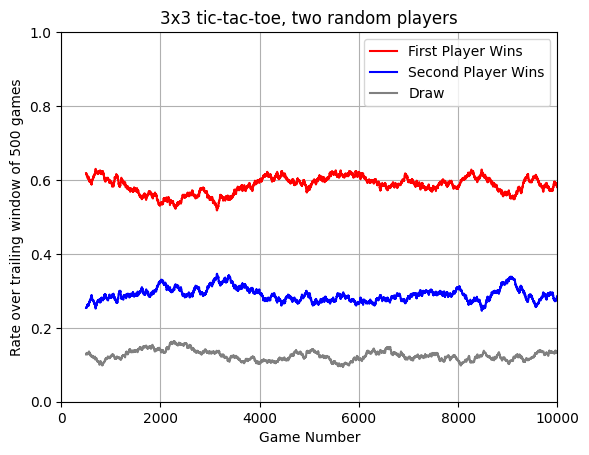

In [9]:
def moving(data, value=+1, size=100):
# simple rolling mean over size values
    binary_data = [x == value for x in data]
    return [sum(binary_data[i-size:i])/size for i in range(size, len(data) + 1)]

def show(results, size=500, title='Moving average of game outcomes',
         first_label='First Player Wins', second_label='Second Player Wins', draw_label='Draw'):
    x_values = range(size, len(results) + 1)
    first = moving(results, value=+1, size=size)
    second = moving(results, value=-1, size=size)
    draw = moving(results, value=0, size=size)
    first, = plt.plot(x_values, first, color='red', label=first_label)
    second, = plt.plot(x_values, second, color='blue', label=second_label)
    draw, = plt.plot(x_values, draw, color='grey', label=draw_label)
    plt.xlim([0, len(results)])
    plt.ylim([0, 1])
    plt.title(title)
    plt.legend(handles=[first, second, draw], loc='best')
    plt.ylabel(f'Rate over trailing window of {size} games')
    plt.xlabel('Game Number')
    plt.grid()
    plt.show()
    
show(res, title='3x3 tic-tac-toe, two random players')

In [10]:
class Agent(Player):    
    def __init__(self, size, seed, loadNN=False):
        self.size = 3
        self.training = True
        self.in_game_training = True
        if loadNN:
            self.model.load_model('data/TicTacToe.h5')
        else:
            # Single fc layer of size*size neurons (all possible moves)
            self.model = tf.keras.Sequential()
            self.model.add(tf.keras.layers.Dense(size**2,
                                                 kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed),
                                                 input_dim=9)
                          )
            self.model.compile(optimizer='Adam', loss='mean_squared_error')

    def predict_q(self, board):            
        pred = self.model.predict(np.array([board.ravel()]))
        return pred.reshape(3,3)
                                  

    def fit_q(self, board, q_values):
        self.model.fit(
            np.array([board.ravel()]), np.array([q_values.ravel()]), verbose=0)
        # print('Fitting:')
        # print(np.array([board.ravel()]))
        # print('Target')
        # print(np.array([q_values.ravel()]))
        

    def new_game(self):
        self.last_move = None
        self.board_history = []
        self.q_history = []

    def move(self, board):
        # always ask the agent to play the same side
        q_values = self.predict_q(board)
        temp_q = q_values.copy()
        temp_q[board != 0] = temp_q.min() - 1  # no illegal moves
        move = np.unravel_index(np.argmax(temp_q), board.shape)
        value = temp_q.max()
        if self.training and self.in_game_training and self.last_move is not None:
            self.reward(value)
        self.board_history.append(board.copy())
        self.q_history.append(q_values)
        self.last_move = move
        return move

    def reward(self, reward_value):
        if not self.training:
            return
        new_q = self.q_history[-1].copy()
        new_q[self.last_move] = reward_value

        if reward_value >0 :
            self.fit_q(self.board_history[-1], new_q)  # Incremental fit over all games
    
    def save(self, fileName):
        self.model.save_weights('data/TicTacToe_weights.h5')
        np.save('data/board_history.dat', self.board_history)
        np/save('data/q_history.dat', self.q_history)

In [11]:
# 3x3, q-learning vs. random

from datetime import datetime

random.seed(4)
agent = Agent(3, seed=4)
print('Staring Q-learning:',datetime.now().strftime("%H:%M:%S"))
# results = [play(new_board(3), {+1: agent, -1: RandomPlayer()}) for _ in range(2000)]
results = [play(new_board(3), {+1: agent, -1: RandomPlayer()}) for _ in range(2000)]

print('Finishing Q-learning:', datetime.now().strftime("%H:%M:%S"))

res = [ y for (x,y) in results]
collections.Counter(res)

Metal device set to: Apple M2 Pro
Staring Q-learning: 08:25:30
1/1 [==============================] - 0s 9ms/step


2023-12-12 08:25:30.524785: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 7ms/step
Finishing Q-learning: 08:30:38


Counter({0: 52, 1.0: 1733, -1.0: 215})

In [12]:
agent.model.save('data/TicTacToe.h5')
agent.model.save_weights('data/TicTacToe_weights.h5')

agent.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________


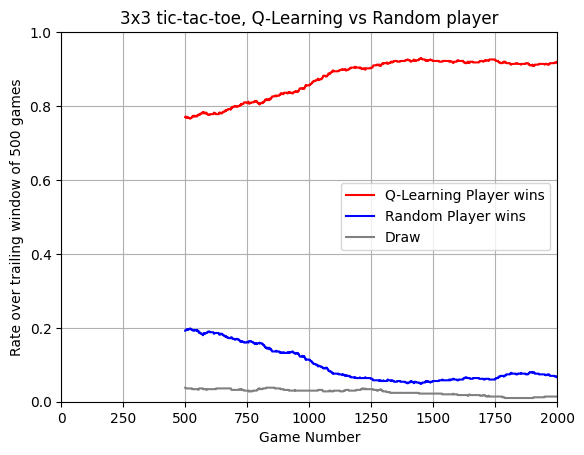

In [13]:
show(res, title='3x3 tic-tac-toe, Q-Learning vs Random player', first_label='Q-Learning Player wins', second_label='Random Player wins')

### Some examples of ravel/unravel_index applications

In [14]:
b = np.arange(1,10).reshape(3,3)

In [15]:
np.ravel(b)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
b = b.reshape(9)
b

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
b[8]=5

In [18]:
idx = np.where(b==5)

In [19]:
print(idx, len(idx))

(array([4, 8]),) 1


In [20]:
np.unravel_index(4, (3,3))

(1, 1)

In [21]:
np.unravel_index(8, (3,3))

(2, 2)

# Moving average using convolution

In [22]:
a=np.array([1,2,3,3,3,5,6,4,3,6,7,8,10])

In [23]:
kernel = np.ones(3)/3
kernel

array([0.33333333, 0.33333333, 0.33333333])

In [24]:
np.convolve(a,kernel,mode='valid')

array([2.        , 2.66666667, 3.        , 3.66666667, 4.66666667,
       5.        , 4.33333333, 4.33333333, 5.33333333, 7.        ,
       8.33333333])